*****
# Necessary Library Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [45]:
sys.path.append(os.path.abspath("../")) # get the parent directory
import importlib
from src.data_processing import preprocess, reduce_memory_size
importlib.reload(preprocess)
from src.data_processing.preprocess import *
from src.data_processing.reduce_memory_size import *

**Fixing the display size**

In [3]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) # no limit on the number of columns
pd.set_option('display.max_rows', None)  # no limit on the number of rows
pd.set_option('display.max_colwidth', None) # no limit on the column width

*****
# Dataset Import

In [4]:
df = load_data("D:/Programing/web-attack-detection/data/raw/cic-ids2017.csv")

In [5]:
# create a new status column that contain 'safe: 0' or 'malicious: 1' based on the label column.
df = create_status(df)

# reduce the memory size of the dataframe
df = reduce_memory_size(df)

print(f"Dataframe shape: {df.shape}")

Initial Memory Size: 1201.58 MB
Updated Memory Size: 624.87 MB
Memory Usage Reduced by: 576.71 MB
this is: 52.00% of the initial size
Dataframe shape: (1854979, 79)


*****
# Class Mapping

In [6]:
attack_mapping = {
    "Benign": "Benign",
    "DDoS": "DDoS",
    "DoS Hulk": "DoS",
    "DoS GoldenEye": "DoS",
    "DoS slowloris": "DoS",
    "DoS Slowhttptest": "DoS",
    "FTP-Patator": "Brute Force Attack",
    "SSH-Patator": "Brute Force Attack",
    "Infiltration": "Brute Force Attack",
    "Web Attack – Brute Force": "Web Attack",
    "Web Attack – XSS": "Web Attack",
    "Web Attack – Sql Injection": "Web Attack",
    "Bot": "Botnet",
    "PortScan": "Port Scanning Attack",
    "Heartbleed": "Heartbleed"
}

# map the attack labels to the attack categories
df['Attack Type'] = df["Label"].map(attack_mapping)

# remove the label column
df.drop(columns=["Label"], inplace=True)

# remove samples where the 'attack type' is 'heartbleed' since there is only few samples
df = df[df["Attack Type"] != "Heartbleed"]

In [7]:
df['Attack Type'].value_counts()

Attack Type
Benign                  1518487
DoS                      193745
DDoS                     128014
Brute Force Attack         9186
Port Scanning Attack       1956
Botnet                     1437
Name: count, dtype: int64

*****
# Data Cleaning

In [8]:
# remove duplicate values
df = remove_duplicate_values(df)

In [9]:
# dropping constant columns
constant_columns = find_constant_columns(df)
df = df.drop(constant_columns, axis=1)

In [10]:
# dropping identical or duplicate columns
identical_columns, original_columns, duplicate_columns = find_duplicate_columns(df)
df = df.drop(duplicate_columns, axis=1)

In [11]:
# dropping low variance columns whose variance are less than 0.01
low_variance_columns = find_low_variance_columns(df, 0.01)
df = df.drop(low_variance_columns, axis=1)

In [12]:
df.shape

(1776123, 62)

*****
# Categorical Encoding

In [13]:
label_encoder = LabelEncoder()
df["Attack Type"] = label_encoder.fit_transform(df["Attack Type"])

# save the classes for decode later
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Encoded Classes: ")
print(class_mapping)

Encoded Classes: 
{'Benign': 0, 'Botnet': 1, 'Brute Force Attack': 2, 'DDoS': 3, 'DoS': 4, 'Port Scanning Attack': 5, nan: 6}


In [14]:
# save encoding dictionary to a JSON file
import json

encoding_mapping = {str(k): str(v) for k, v in class_mapping.items()}
with open("D:\Programing\web-attack-detection\data\processed\encoding_mapping.json", 'w') as file:
    json.dump(encoding_mapping, file, indent=1)

In [15]:
# save the encoder 
import joblib

path = "D:\Programing\web-attack-detection\data\processed\encoding_mapping.pkl"
joblib.dump(label_encoder, path)

['D:\\Programing\\web-attack-detection\\data\\processed\\encoding_mapping.pkl']

In [16]:
df['Attack Type'].value_counts()

Attack Type
0    1439642
4     193745
3     128014
2       9186
6       2143
5       1956
1       1437
Name: count, dtype: int64

In [17]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Avg Packet Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,status,Attack Type
0,6,112740690,32,16,6448,1152,403,0,201.5,204.724197,72,72,72.0,0.0,67.411331,0.425756,2398738.000,5798698.000,16400000,3,113000000,3636796.500,6848761.000,16400000,3,113000000,7516023.0,8323385.0,16400000,3,1,1024,512,0.283837,0.141919,0,403,163.326538,178.931717,32016.559,0,0,1,0,0,166.729172,6448,1152,377,2079,15,32,3.594286e+02,1.199802e+01,380,343,16100000.0,498804.80,16400000,15400000,0,0
1,6,112740560,32,16,6448,5056,403,0,201.5,204.724197,316,316,316.0,0.0,102.039585,0.425756,2398735.200,5798709.500,16400000,2,113000000,3636792.200,6848777.000,16400000,2,113000000,7516016.0,8323376.0,16400000,4,1,1024,512,0.283838,0.141919,0,403,243.000000,174.716919,30526.000,0,0,1,0,0,248.062500,6448,5056,955,2079,15,32,3.202857e+02,1.574499e+01,330,285,16100000.0,498793.66,16400000,15400000,0,0
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,0,0,0.0,0.0,0.000000,4.790898,209112.830,1395543.400,20800000,0,114000000,209112.830,1395543.400,20800000,0,0,0.0,0.0,0,0,0,0,0,4.790898,0.000000,0,0,0.000000,0.000000,0.000,0,0,0,0,0,0.000000,0,0,-1,-1,0,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6935824.00,20800000,5504997,0,0
3,17,100126,22,0,616,0,28,28,28.0,0.000000,0,0,0.0,0.0,6152.248167,219.723149,4767.905,21833.020,100055,1,100126,4767.905,21833.020,100055,1,0,0.0,0.0,0,0,0,704,0,219.723140,0.000000,28,28,28.000000,0.000000,0.000,0,0,0,0,0,29.272728,616,0,-1,-1,21,32,0.000000e+00,0.000000e+00,0,0,0.0,0.00,0,0,0,0
4,0,54760,4,0,0,0,0,0,0.0,0.000000,0,0,0.0,0.0,0.000000,73.046019,18253.334,30469.836,53431,108,54760,18253.334,30469.836,53431,108,0,0.0,0.0,0,0,0,0,0,73.046020,0.000000,0,0,0.000000,0.000000,0.000,0,0,0,0,0,0.000000,0,0,-1,-1,0,0,0.000000e+00,0.000000e+00,0,0,0.0,0.00,0,0,0,0


*****
# Correlation Analysis

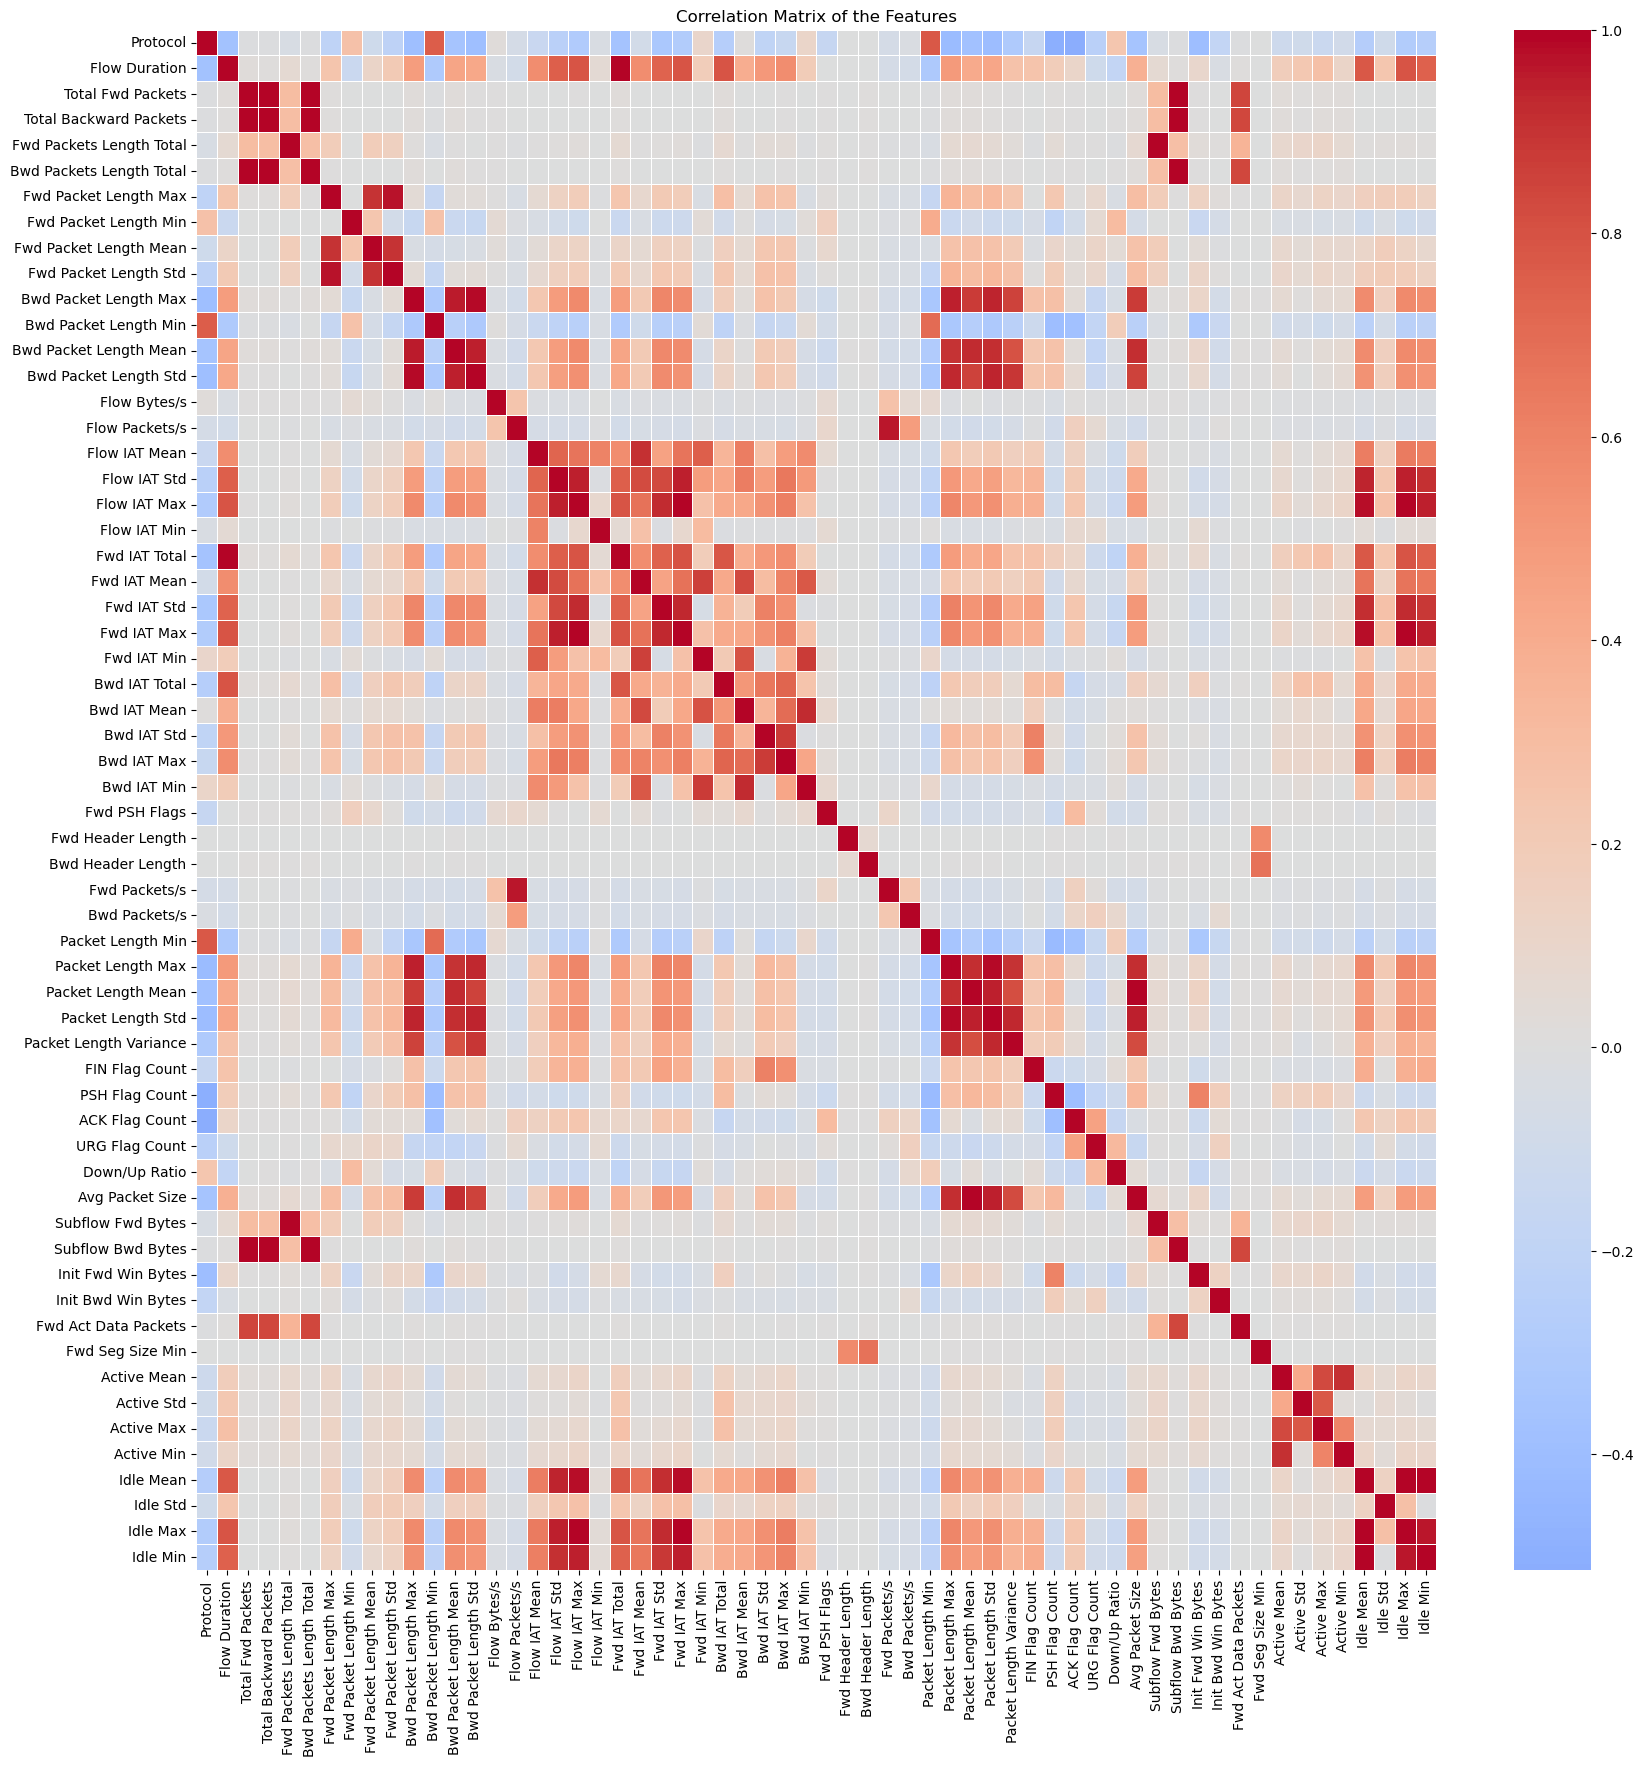

In [30]:
# plot the correlation matrix and find the highly correlated features
high_correlated_features = correlation_analysis(df=df, target_column=['Attack Type', 'status'])

In [31]:
# print the highly correlated features
high_multicollinearity = []

for item in high_correlated_features:
    if item[2] > 0.95:
        print(f"{item[0]} and {item[1]} correlation: {item[2].round(4)}")
        high_multicollinearity.append(item)

Total Backward Packets and Total Fwd Packets correlation: 0.999
Bwd Packets Length Total and Total Fwd Packets correlation: 0.9963
Bwd Packets Length Total and Total Backward Packets correlation: 0.9934
Fwd Packet Length Std and Fwd Packet Length Max correlation: 0.972
Bwd Packet Length Mean and Bwd Packet Length Max correlation: 0.9586
Bwd Packet Length Std and Bwd Packet Length Max correlation: 0.9836
Fwd IAT Total and Flow Duration correlation: 0.9987
Fwd IAT Max and Flow IAT Max correlation: 0.9984
Fwd Packets/s and Flow Packets/s correlation: 0.9607
Packet Length Std and Packet Length Max correlation: 0.9841
Avg Packet Size and Packet Length Mean correlation: 0.9984
Subflow Fwd Bytes and Fwd Packets Length Total correlation: 1.0
Subflow Bwd Bytes and Total Fwd Packets correlation: 0.9963
Subflow Bwd Bytes and Total Backward Packets correlation: 0.9934
Subflow Bwd Bytes and Bwd Packets Length Total correlation: 1.0
Idle Mean and Flow IAT Max correlation: 0.9819
Idle Mean and Fwd IA

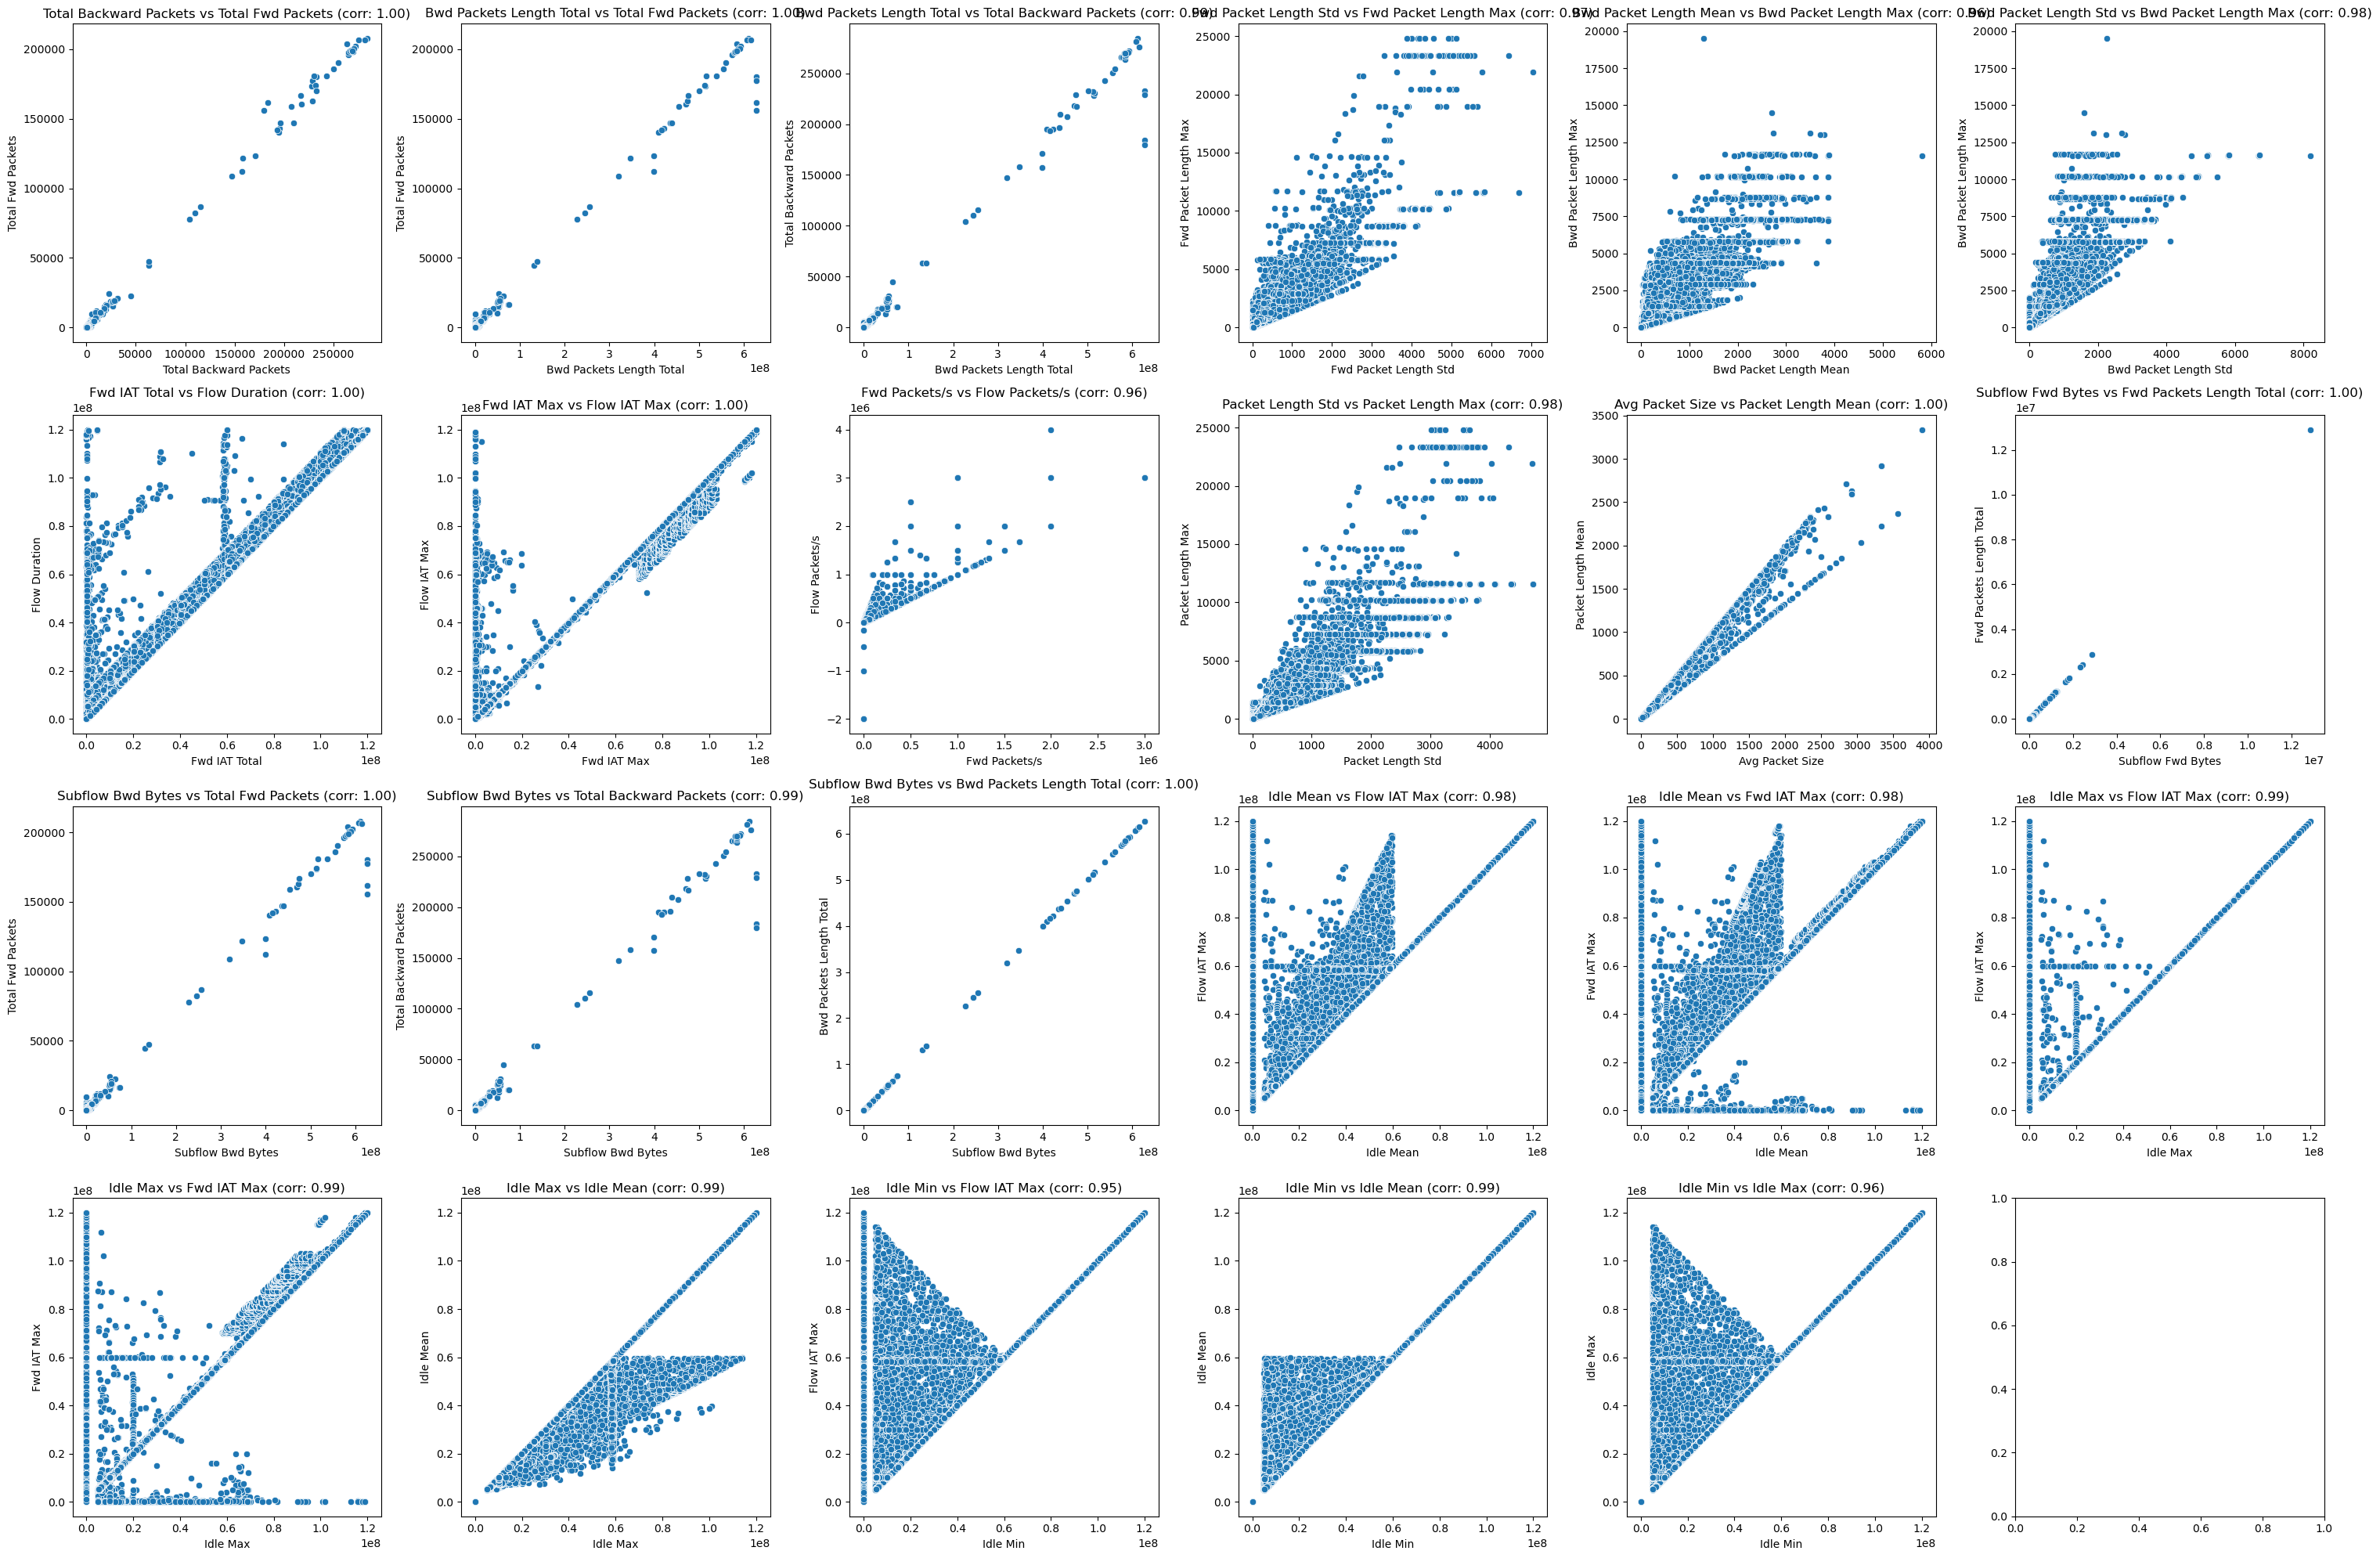

In [34]:
# plotting the pair plots of highly correlated features
n = len(high_multicollinearity)
col = 6
row = (n+col-1)//col

fig, axes = plt.subplots(row, col, figsize=(30, 5*row))
axes = axes.ravel()

for i, item in enumerate(high_multicollinearity):
    f_x = item[0]
    f_y = item[1]
    corr_value = item[2]
    
    sns.scatterplot(x=df[f_x], y=df[f_y], ax=axes[i])
    axes[i].set_title(f"{f_x} vs {f_y} (corr: {corr_value:.2f})")

plt.tight_layout()
plt.show()

In [35]:
# drop the highly correlated features
high_redundant_features = ['Total Backward Packets', 'Subflow Bwd Bytes']
df = df.drop(high_redundant_features, axis=1)

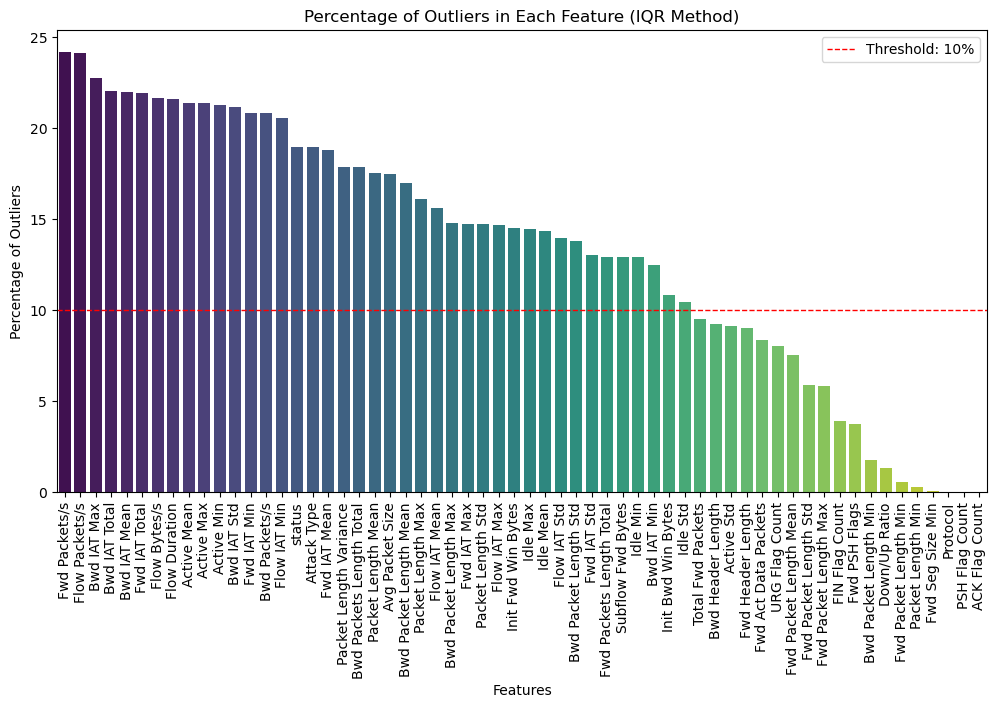

In [ ]:
outlier_percentages = calculate_outliers_percentage(df)
sorted_outliers = dict(sorted(outlier_percentages.items(), key=lambda item: item[1], reverse=True))
threshold = 10

plt.figure(figsize=(12, 6))
sns.barplot(x=list(sorted_outliers.keys()), y=list(sorted_outliers.values()), palette='viridis')

plt.axhline(y=threshold, color='r', linestyle='--', linewidth=1, label=f'Threshold: {threshold}%')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers in Each Feature (IQR Method)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
file_path = "D:/Programing/web-attack-detection/data/modified/cic-ids2017.csv"

save_data(df, file_path)

Error saving the modified dataset: name 'df' is not defined


*****
# Data Balancing (SMOTE)

In [4]:
from imblearn.over_sampling import SMOTE
df = load_data("D:/Programing/web-attack-detection/data/modified/cic-ids2017.csv")
print(df.shape)
df = reduce_memory_size(df)

(1776123, 60)
Initial Memory Size: 813.04 MB
Updated Memory Size: 443.79 MB
Memory Usage Reduced by: 369.26 MB
this is: 54.58% of the initial size


In [5]:
# separate the safe and malicious samples
safe_samples = df[df['status'] == 0]
malicious_samples = df[df['status'] == 1]

malicious_class_counts = malicious_samples['Attack Type'].value_counts() 
print(f"Total Malicious Samples: {malicious_class_counts.sum()}")   # total malicious samples
MAX_MALICIOUS_CLASS = malicious_class_counts.max()    # finding the maximum malicious class samples
print(f"Maximum Malicious class Samples: {MAX_MALICIOUS_CLASS}")

Total Malicious Samples: 336481
Maximum Malicious class Samples: 193745


In [6]:
# split the dataset into features and target columns
target_columns = ['Attack Type', 'status']
X = malicious_samples.drop(columns=target_columns)
y_attack = malicious_samples['Attack Type']
y_status = malicious_samples['status']

In [7]:
# define SMOTe strategy
smote_strategy = {
    1: MAX_MALICIOUS_CLASS,  
    2: MAX_MALICIOUS_CLASS,  
    3: MAX_MALICIOUS_CLASS,
    4: MAX_MALICIOUS_CLASS,  
    5: MAX_MALICIOUS_CLASS,  
    6: MAX_MALICIOUS_CLASS   
}

smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y_attack)   # resample the attack type column

malicious_class_resampled = pd.DataFrame(X_resampled, columns=X.columns)
malicious_class_resampled['Attack Type'] = y_resampled
malicious_class_resampled['status'] = malicious_class_resampled['Attack Type'].apply(lambda x: 0 if x == 0 else 1)

print(f"Resampled Malicious Dataset shape: {malicious_class_resampled.shape}")

Resampled Malicious Dataset shape: (1162470, 60)


### Balance the datasets malicious class using SMOTE by resampling all malicious classes (except class 0) to match the Maximum malicious class count. First Processed dataset contain all the safe samples and balanced malicious samples.

In [10]:
# concatenate the safe and resampled malicious samples
df_malicious_resampled = pd.concat([safe_samples, malicious_class_resampled], axis=0)
print("New Dataset contain same amount of safe samples and resampled the malicious samples")
print("New first dataset shape: ", df_malicious_resampled.shape)

# reduce the memory size of the dataset
df_malicious_resampled = reduce_memory_size(df_malicious_resampled)

# save the resampled dataset
file_path = "D:/Programing/web-attack-detection/data/processed/malicious_balanced_safe_same.csv"
save_data(df_malicious_resampled, file_path)

New Dataset contain same amount of safe samples and resampled the malicious samples
New first dataset shape:  (2602112, 60)
Initial Memory Size: 687.39 MB
Updated Memory Size: 670.02 MB
Memory Usage Reduced by: 17.37 MB
this is: 97.47% of the initial size
Data has been saved successfully


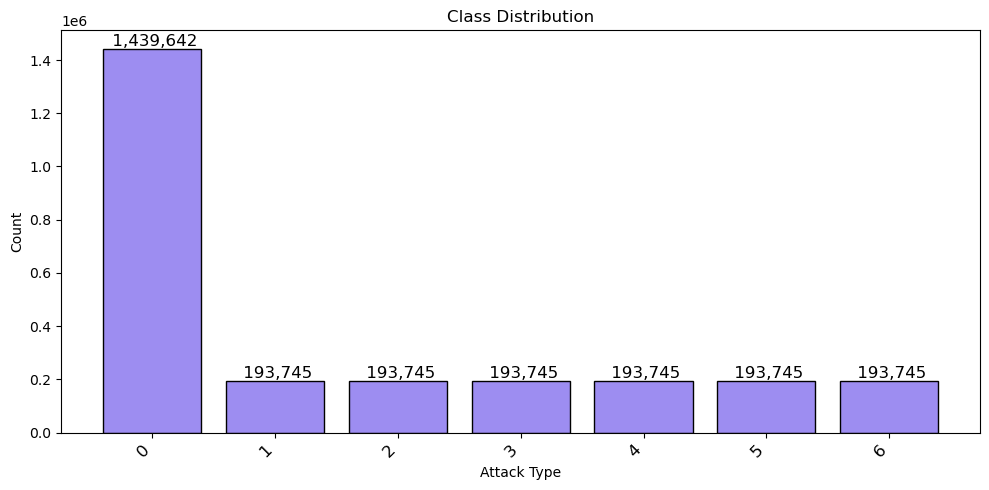

In [15]:
print_label_distribution(df_malicious_resampled, 'Attack Type',10)

### Reduce the Benign class into 25%. Balance the datasets malicious class using SMOTE by resampling all malicious classes (except class 0) to match the Maximum malicious class count. The second processed dataset contain 25% of the safe samples and balanced malicious samples.

In [17]:
new_safe_size = int(0.25* len(safe_samples))
print(f"Safe samples size will be: {new_safe_size}")

# randomly select 25% samples of the safe class
new_safe_samples = safe_samples.sample(n=new_safe_size, random_state=42)
print(f"New safe samples size: {new_safe_samples.shape}")

df_reduced_safe_malicious_resampled = pd.concat([new_safe_samples, malicious_class_resampled], axis=0)  # concatenate the safe and malicious samples
print("New Second Dataset contain 25 percent of safe samples and resampled the malicious samples")
print(f"New Second Balanced dataset shape: {df_reduced_safe_malicious_resampled.shape}")

# reduce the memory size of the dataset
df_reduced_safe_malicious_resampled = reduce_memory_size(df_reduced_safe_malicious_resampled)

# save the new resampled dataset
file_path = "D:/Programing/web-attack-detection/data/processed/malicious_balanced_safe_reduced.csv"
save_data(df_reduced_safe_malicious_resampled, file_path)

Safe samples size will be: 359910
New safe samples size: (359910, 60)
New Second Dataset contain 25 percent of safe samples and resampled the malicious samples
New Second Balanced dataset shape: (1522380, 60)
Initial Memory Size: 402.16 MB
Updated Memory Size: 390.55 MB
Memory Usage Reduced by: 11.61 MB
this is: 97.11% of the initial size
Data has been saved successfully


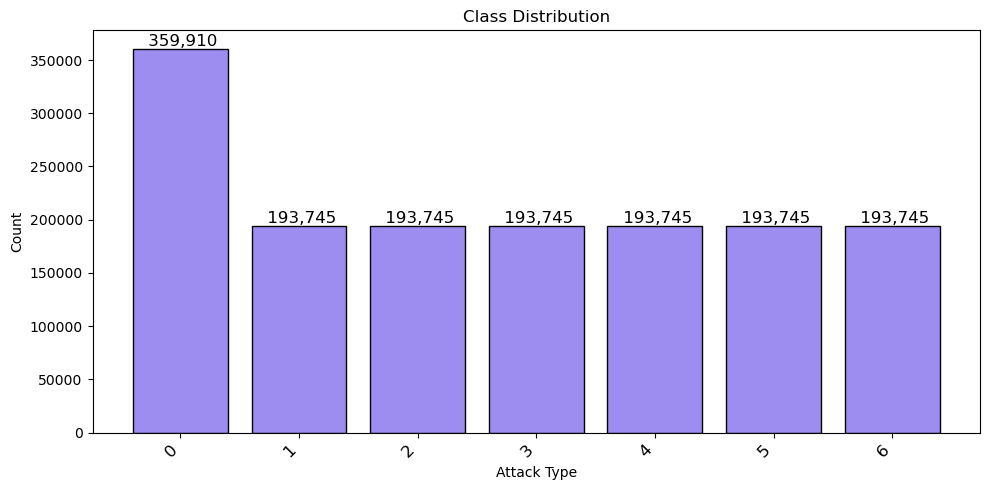

In [18]:
print_label_distribution(df_reduced_safe_malicious_resampled, 'Attack Type', 10)

*****
# Feature Selection operation was perform in another notebook using the XGBoost Model. 
*****

*****
# Pre-process the first dataset (malicious_balanced_safe_same.csv) for model. 

In [28]:
df_malicious_resampled.head()

,Protocol,Flow Duration,Total Fwd Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Avg Packet Size,Subflow Fwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,status,Attack Type
0,6,112740690,32,6448,1152,403,0,201.5,204.724197,72,72,72.0,0.0,67.411331,0.425756,2398738.000,5798698.000,16400000,3,113000000,3636796.500,6848761.000,16400000,3,113000000,7516023.0,8323385.0,16400000,3,1,1024,512,0.283837,0.141919,0,403,163.326538,178.931717,32016.559,0,0,1,0,0,166.729172,6448,377,2079,15,32,3.594286e+02,1.199802e+01,380,343,16100000.0,498804.80,16400000,15400000,0,0
1,6,112740560,32,6448,5056,403,0,201.5,204.724197,316,316,316.0,0.0,102.039585,0.425756,2398735.200,5798709.500,16400000,2,113000000,3636792.200,6848777.000,16400000,2,113000000,7516016.0,8323376.0,16400000,4,1,1024,512,0.283838,0.141919,0,403,243.000000,174.716919,30526.000,0,0,1,0,0,248.062500,6448,955,2079,15,32,3.202857e+02,1.574499e+01,330,285,16100000.0,498793.66,16400000,15400000,0,0
2,0,113757377,545,0,0,0,0,0.0,0.000000,0,0,0.0,0.0,0.000000,4.790898,209112.830,1395543.400,20800000,0,114000000,209112.830,1395543.400,20800000,0,0,0.0,0.0,0,0,0,0,0,4.790898,0.000000,0,0,0.000000,0.000000,0.000,0,0,0,0,0,0.000000,0,-1,-1,0,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6935824.00,20800000,5504997,0,0
3,17,100126,22,616,0,28,28,28.0,0.000000,0,0,0.0,0.0,6152.248167,219.723149,4767.905,21833.020,100055,1,100126,4767.905,21833.020,100055,1,0,0.0,0.0,0,0,0,704,0,219.723140,0.000000,28,28,28.000000,0.000000,0.000,0,0,0,0,0,29.272728,616,-1,-1,21,32,0.000000e+00,0.000000e+00,0,0,0.0,0.00,0,0,0,0
4,0,54760,4,0,0,0,0,0.0,0.000000,0,0,0.0,0.0,0.000000,73.046019,18253.334,30469.836,53431,108,54760,18253.334,30469.836,53431,108,0,0.0,0.0,0,0,0,0,0,73.046020,0.000000,0,0,0.000000,0.000000,0.000,0,0,0,0,0,0.000000,0,-1,-1,0,0,0.000000e+00,0.000000e+00,0,0,0.0,0.00,0,0,0,0


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib 

top_features=['Bwd Packet Length Min', 'Fwd PSH Flags', 'Packet Length Max', 'Idle Max', 'PSH Flag Count', 'Bwd Header Length', 'Active Max', 'Idle Min', 'Bwd IAT Min', 'Bwd Packets Length Total', 'Fwd Packet Length Mean',
 'Packet Length Std', 'Fwd Act Data Packets', 'FIN Flag Count', 'Bwd Packet Length Std', 'Fwd Packets Length Total', 'Fwd IAT Std', 'Fwd Header Length', 'Avg Packet Size', 'Flow IAT Max', 'Fwd Packet Length Std', 'Bwd Packets/s',
 'Fwd Packet Length Max', 'Packet Length Mean', 'Packet Length Min', 'Total Fwd Packets', 'Flow IAT Std', 'Fwd Seg Size Min', 'Fwd IAT Max', 'Down/Up Ratio']

targets = ['Attack Type', 'status']
X_ds1 = df_malicious_resampled[top_features]
y_ds1 = df_malicious_resampled[targets]

print(f"Shape of X of first dataset: {X_ds1.shape}")
print(f"Shape of y of first dataset: {y_ds1.shape}")

X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X_ds1, y_ds1, test_size=0.3, random_state=42)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_temp1, y_temp1, test_size=0.5, random_state=42)

scaler1 = StandardScaler()

# scale the training, validation, test data
X_train1_scaled = scaler1.fit_transform(X_train1)
X_val1_scaled = scaler1.transform(X_val1)
X_test1_scaled = scaler1.transform(X_test1)

# save the scaler 
path = "D:\Programing\web-attack-detection\data\processed\safe_same_and_malicious_balanced\scaler.pkl"
joblib.dump(scaler1, path)

Shape of X of first dataset: (2602112, 30)
Shape of y of first dataset: (2602112, 2)


['D:\\Programing\\web-attack-detection\\data\\processed\\safe_same_and_malicious_balanced\\scaler.pkl']

In [ ]:
file_path = "D:\Programing\web-attack-detection\data\processed\safe_same_and_malicious_balanced"

save_split_data(X_train1_scaled, top_features, file_path, 'X_train.csv')
save_split_data(X_val1_scaled, top_features, file_path, 'X_val.csv')
save_split_data(X_test1_scaled, top_features, file_path, 'X_test.csv')

save_split_data(y_train1, targets, file_path, 'y_train.csv')
save_split_data(y_val1, targets, file_path, 'y_val.csv')
save_split_data(y_test1, targets, file_path, 'y_test.csv')

print("Datasets saved successfully.")

Datasets and scaler saved successfully.


*****
# Pre-process the Second dataset (malicious_balanced_safe_reduced.csv) for model. 

In [65]:
df_reduced_safe_malicious_resampled = load_data("D:/Programing/web-attack-detection/data/processed/malicious_balanced_safe_reduced.csv")

In [66]:
X_ds2 = df_reduced_safe_malicious_resampled[top_features]
y_ds2 = df_reduced_safe_malicious_resampled[targets]

print(f"Shape of X of Second dataset: {X_ds2.shape}")
print(f"Shape of y of Second dataset: {y_ds2.shape}")

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X_ds2, y_ds2, test_size=0.3, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

scaler2 = StandardScaler()

# scale the training, validation, test data
X_train2_scaled = scaler2.fit_transform(X_train1)
X_val2_scaled = scaler2.transform(X_val1)
X_test2_scaled = scaler2.transform(X_test1)

# save the scaler 
path = "D:\Programing\web-attack-detection\data\processed\safe_reduced_and_malicious_balanced\scaler.pkl"
joblib.dump(scaler2, path)

Shape of X of Second dataset: (1522380, 30)
Shape of y of Second dataset: (1522380, 2)


['D:\\Programing\\web-attack-detection\\data\\processed\\safe_reduced_and_malicious_balanced\\scaler.pkl']

In [67]:
file_path = "D:\Programing\web-attack-detection\data\processed\safe_reduced_and_malicious_balanced"

save_split_data(X_train2_scaled, top_features, file_path, 'X_train.csv')
save_split_data(X_val2_scaled, top_features, file_path, 'X_val.csv')
save_split_data(X_test2_scaled, top_features, file_path, 'X_test.csv')

save_split_data(y_train2, targets, file_path, 'y_train.csv')
save_split_data(y_val2, targets, file_path, 'y_val.csv')
save_split_data(y_test2, targets, file_path, 'y_test.csv')

print("Datasets saved successfully.")

Datasets saved successfully.


In [62]:
xtr = load_data("D:/Programing/web-attack-detection/data/processed/safe_same_and_malicious_balanced/X_train.csv")

xv  = load_data("D:/Programing/web-attack-detection/data/processed/safe_same_and_malicious_balanced/X_val.csv")

xte = load_data("D:/Programing/web-attack-detection/data/processed/safe_same_and_malicious_balanced/X_test.csv")


xtr.shape, xv.shape, xte.shape

((1821478, 30), (390317, 30), (390317, 30))

In [68]:
xtr = load_data("D:/Programing/web-attack-detection/data/processed/safe_reduced_and_malicious_balanced/X_train.csv")

xv  = load_data("D:/Programing/web-attack-detection/data/processed/safe_reduced_and_malicious_balanced/X_val.csv")

xte = load_data("D:/Programing/web-attack-detection/data/processed/safe_reduced_and_malicious_balanced/X_test.csv")


xtr.shape, xv.shape, xte.shape

((1821478, 30), (390317, 30), (390317, 30))